In [74]:
%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# # cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
# #                          cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
# #                          cluster_bidirected_edges=[('C2', 'C3')])
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
#                          cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
#                          cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])
# # cluster_dag.cluster_graph.draw_pydot_graph()

In [76]:
simulation = Simulator(n_nodes = 10, n_edges = 10, n_clusters = 3, seed = 232)
cluster_dag = simulation.run_with_latents(no_of_latent_vars = 5)

INFO: Finished synthetic dataset


Inducing path found: ['X15', 'X2', 'X7']
Inducing path found: ['X5', 'X2', 'X7']
Inducing path found: ['X5', 'X15', 'X7']
Inducing path found: ['X5', 'X2', 'X9', 'X7']
Inducing path found: ['X7', 'X2', 'X5']
Inducing path found: ['X7', 'X2', 'X9']
Inducing path found: ['X7', 'X15', 'X5']
Inducing path found: ['X7', 'X15', 'X8']
Inducing path found: ['X7', 'X9', 'X2', 'X5']
Inducing path found: ['X7', 'X2', 'X15']
Inducing path found: ['X8', 'X15', 'X7']
Inducing path found: ['X9', 'X2', 'X7']


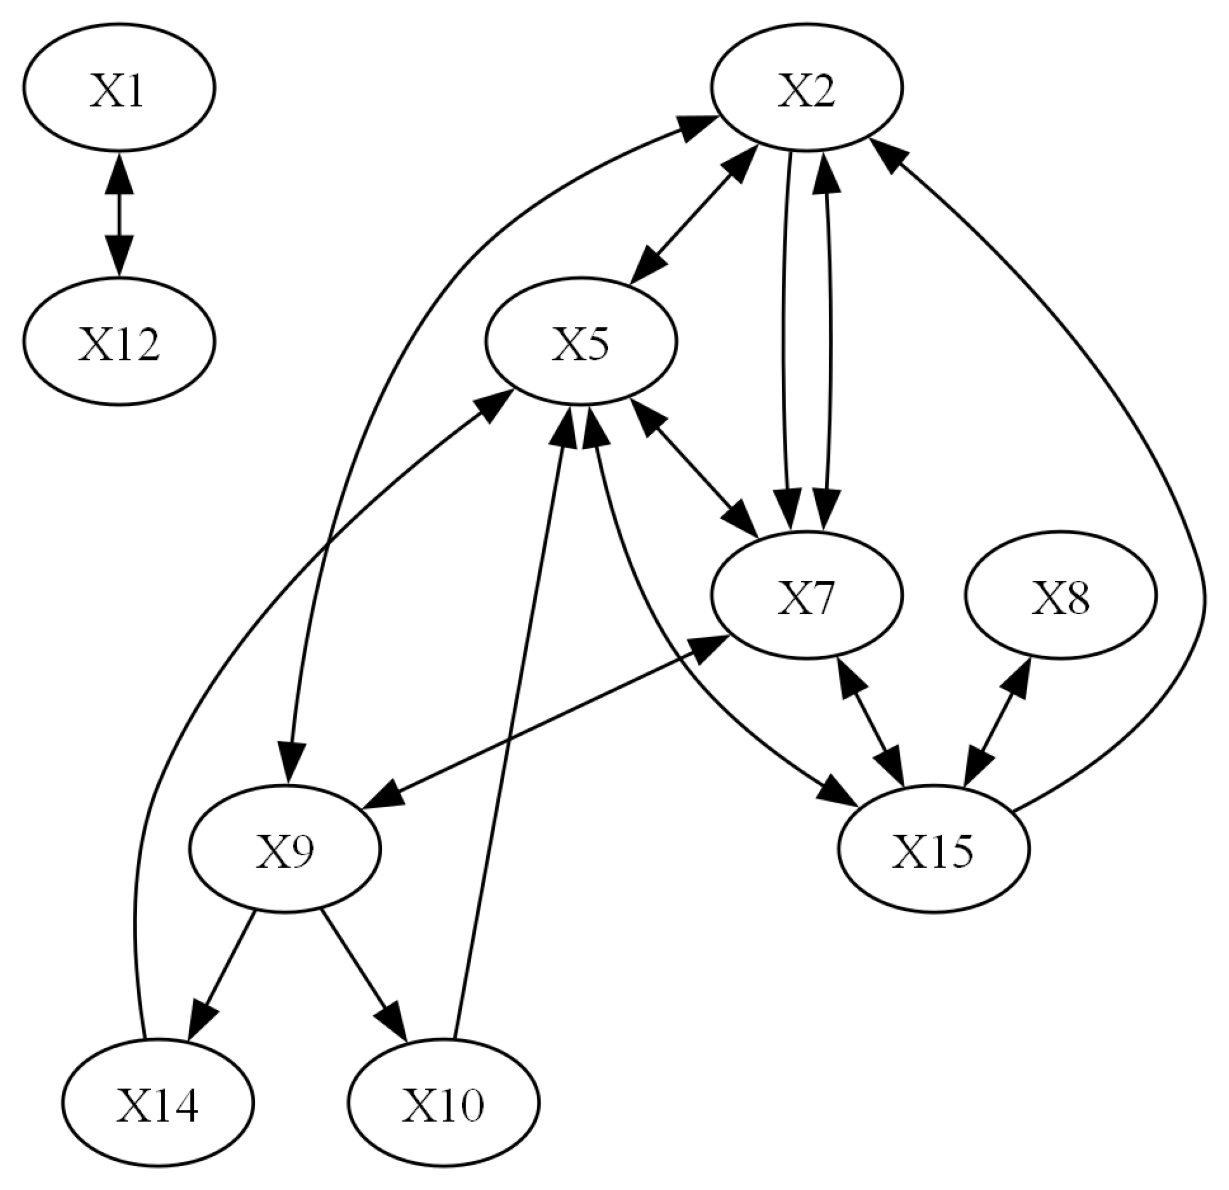

In [77]:
cluster_dag.true_dag.draw_pydot_graph()

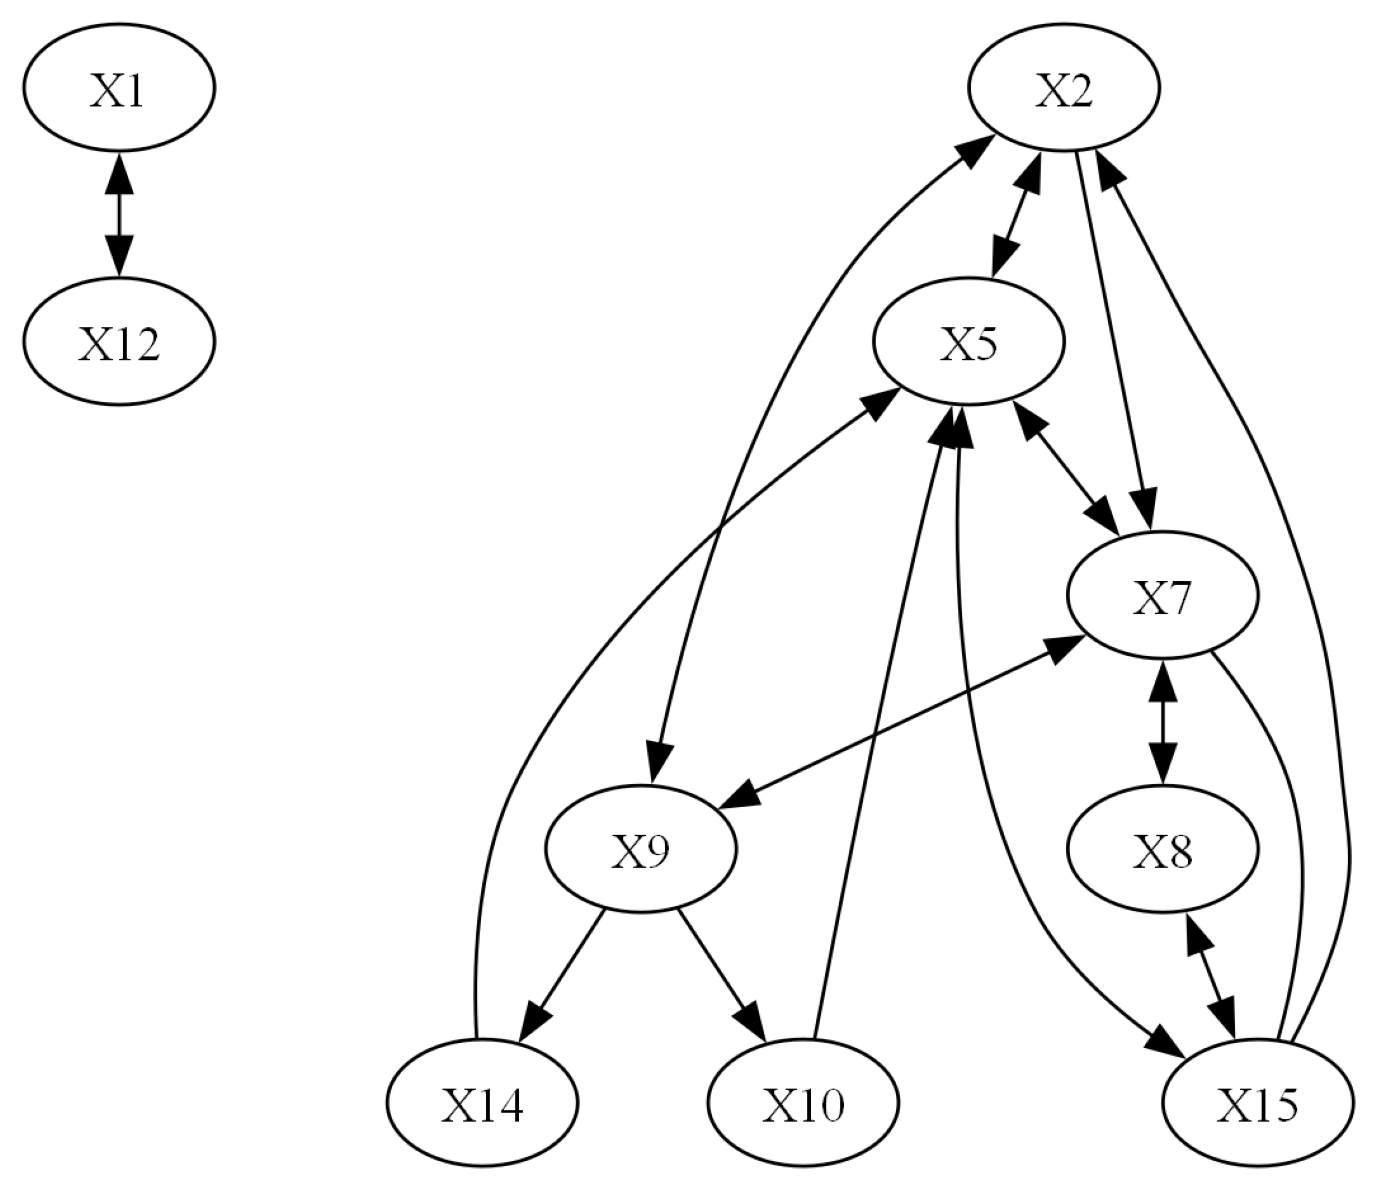

In [78]:
cluster_dag.true_mag.draw_pydot_graph()

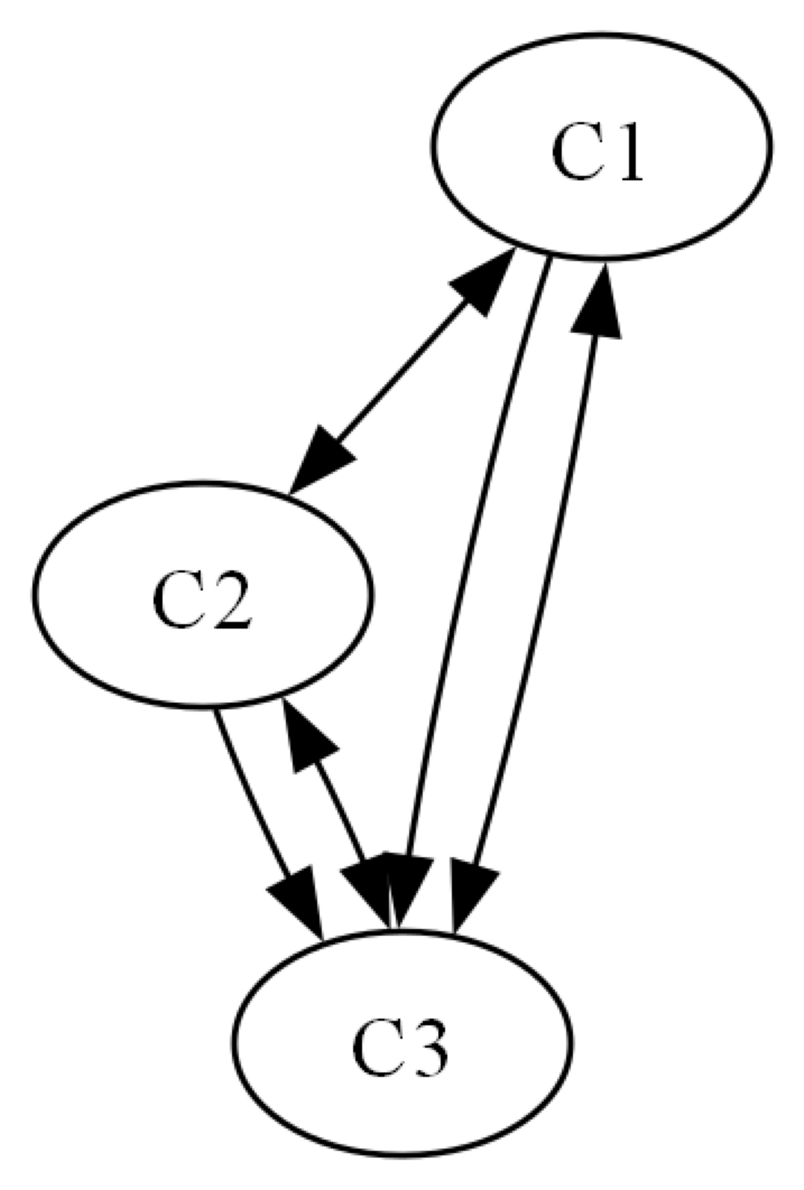

In [79]:
cluster_dag.cluster_graph.draw_pydot_graph()

Found inducing path between C1 and C3: ['C1', 'C2', 'C3']
Found inducing path between C1 and C3: ['C1', 'C2', 'C3']
Found inducing path between C2 and C3: ['C2', 'C1', 'C3']
Found inducing path between C3 and C1: ['C3', 'C2', 'C1']
Found inducing path between C3 and C1: ['C3', 'C2', 'C1']
Found inducing path between C3 and C2: ['C3', 'C1', 'C2']


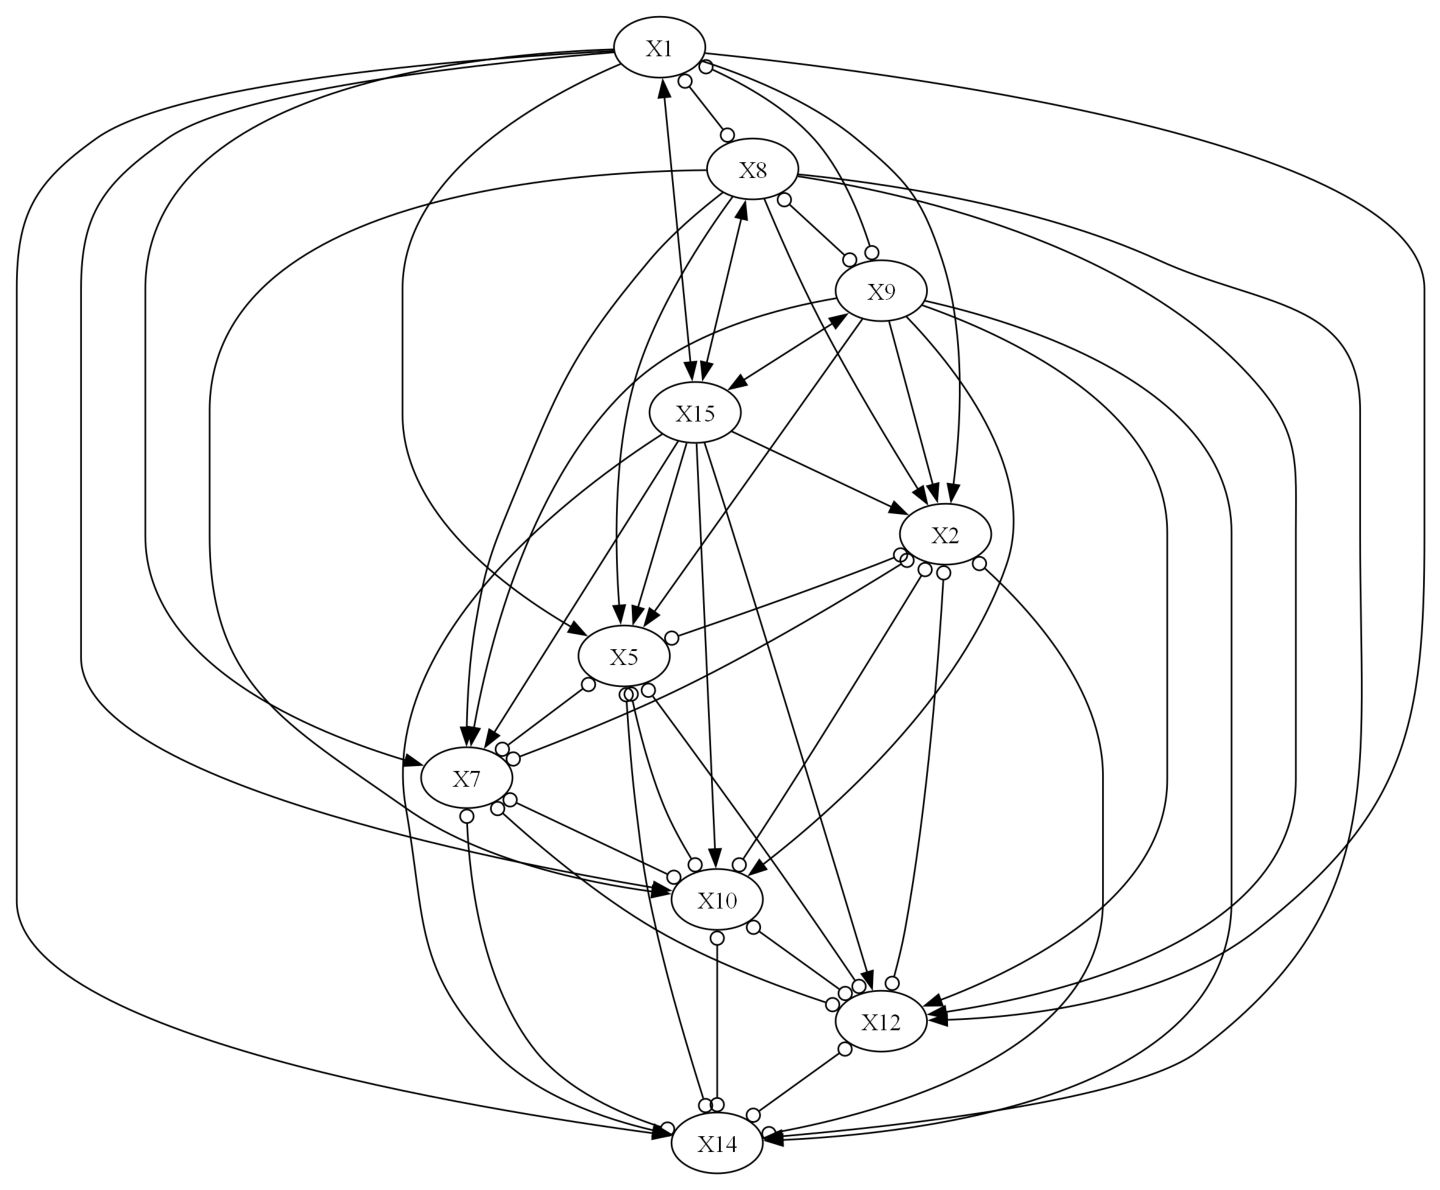

In [80]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [81]:
dic = {'X1': [0], 'X2': [1], 'X3': [2], 'X4': [3], 'X5': [4], 'X6': [5], 'X7': [6], 'X8': [7], 'X9': [8]}
dic['X1'].append(dic['X1'] + [1])

In [82]:
dic

{'X1': [0, [0, 1]],
 'X2': [1],
 'X3': [2],
 'X4': [3],
 'X5': [4],
 'X6': [5],
 'X7': [6],
 'X8': [7],
 'X9': [8]}

In [83]:
[1,2,3][1:-1]

[2]

In [84]:
[1,2,3][-1]

3